In [147]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics, layers, models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
tf.get_logger().setLevel('INFO')

import os
from os import listdir
from PIL import Image


from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from xgboost import XGBClassifier

from vit_keras import vit, utils

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## Might need to install SMOTE. After install, I needed to close anaconda/jupyter notebook and reopen it for it to
## work :) - Kara
##Also import opencv-python for image augmentation- Negin
# import sys
# !{sys.executable} -m pip install imbalanced-learn
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install vit-keras
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install pydot

In [2]:
carrigan = False

### Load Data

In [3]:
if carrigan:
  df = pd.read_csv('/content/drive/MyDrive/Kidney Project Data/kidneyData.csv')
else:
  df = pd.read_csv('KidneyImages/kidneyData.csv')

In [4]:
display(df)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [5]:
newsize = (256, 256)

In [6]:
## Read in all images
# First, read in all cyst images

cystImages = []

# Get the correct folder of images
folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"

for images in os.listdir(folder_dir): # For each item in the folder
    if (images.endswith(".jpg")): # If it is a jpg
        image = Image.open(folder_dir + '/' + images) # Open the image
        image = image.resize(newsize) # Resize it to 256x256
        npImage = np.asarray(image) # Turn it into an array
        reshapedImage = npImage[:, :, 0] # Get rid of the last two color values (since it is black and white)
        cystImages.append({'image_id': images[:-4], 'image': reshapedImage}) # Add the information to the dictionary
        
        


[{'image_id': 'Cyst- (630)', 'image': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}, {'image_id': 'Cyst- (260)', 'image': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}, {'image_id': 'Cyst- (1631)', 'image': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}, {'image_id': 'Cyst- (1261)', 'image': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, 

In [7]:
# Then all normal images
normalImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        normalImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [8]:
# Then all stone images
stoneImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        stoneImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [9]:
# Then all tumor images
tumorImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        tumorImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [27]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

## NEW PREPROCESSING FLOW STARTS HERE

In [47]:
## Preprocess the cyst images
# Sort them by image number
cysts = pd.DataFrame(cystImages)
cysts['number'] = cysts['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
cysts = cysts.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
cystsWithLabel = cysts.merge(df, how = 'inner', on = 'image_id')
cystsWithLabel = cystsWithLabel[['image', 'target']]
cystX = cystsWithLabel['image'].to_numpy()
cysty = cystsWithLabel['target'].to_numpy()

# Reshape the array
cystX = np.array([x for x in cystX])
nsamples, nx, ny = cystX.shape
cystX = cystX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
cystX_and_y = np.column_stack((cystX, cysty))
cystX_and_y = pd.DataFrame(cystX_and_y)
cystX_and_y = cystX_and_y.drop_duplicates()
cystX = cystX_and_y.iloc[:,:-1].to_numpy()
cysty = cystX_and_y.iloc[:,-1:].to_numpy()

In [50]:
## Preprocess the stone images
# Sort them by image number
stones = pd.DataFrame(stoneImages)
stones['number'] = stones['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
stones = stones.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
stonesWithLabel = stones.merge(df, how = 'inner', on = 'image_id')
stonesWithLabel = stonesWithLabel[['image', 'target']]
stoneX = stonesWithLabel['image'].to_numpy()
stoney = stonesWithLabel['target'].to_numpy()

# Reshape the array
stoneX = np.array([x for x in stoneX])
nsamples, nx, ny = stoneX.shape
stoneX = stoneX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
stoneX_and_y = np.column_stack((stoneX, stoney))
stoneX_and_y = pd.DataFrame(stoneX_and_y)
stoneX_and_y = stoneX_and_y.drop_duplicates()
stoneX = stoneX_and_y.iloc[:,:-1].to_numpy()
stoney = stoneX_and_y.iloc[:,-1:].to_numpy()


In [57]:
## Preprocess the normal images
# Sort them by image number
norms = pd.DataFrame(normalImages)
norms['number'] = norms['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
norms = norms.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
normsWithLabel = norms.merge(df, how = 'inner', on = 'image_id')
normsWithLabel = normsWithLabel[['image', 'target']]
normsX = normsWithLabel['image'].to_numpy()
normsy = normsWithLabel['target'].to_numpy()

# Reshape the array
normsX = np.array([x for x in normsX])
nsamples, nx, ny = normsX.shape
normsX = normsX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
normsX_and_y = np.column_stack((normsX, normsy))
normsX_and_y = pd.DataFrame(normsX_and_y)
normsX_and_y = normsX_and_y.drop_duplicates()
normsX = normsX_and_y.iloc[:,:-1].to_numpy()
normsy = normsX_and_y.iloc[:,-1:].to_numpy()

In [59]:
## Preprocess the tumor images
# Sort them by image number
tumor = pd.DataFrame(tumorImages)
tumor['number'] = tumor['image_id'].str.extract('\(([\d]+)\)', expand=False).astype(int)
tumor = tumor.sort_values(by = 'number').reset_index(drop = True)

# Add the labels and make arrays
tumorWithLabel = tumor.merge(df, how = 'inner', on = 'image_id')
tumorWithLabel = tumorWithLabel[['image', 'target']]
tumorX = tumorWithLabel['image'].to_numpy()
tumory = tumorWithLabel['target'].to_numpy()

# Reshape the array
tumorX = np.array([x for x in tumorX])
nsamples, nx, ny = tumorX.shape
tumorX = tumorX.reshape((nsamples,nx*ny))

# Remove duplicates and resplit
tumorX_and_y = np.column_stack((tumorX, tumory))
tumorX_and_y = pd.DataFrame(tumorX_and_y)
tumorX_and_y = tumorX_and_y.drop_duplicates()
tumorX = tumorX_and_y.iloc[:,:-1].to_numpy()
tumory = tumorX_and_y.iloc[:,-1:].to_numpy()

In [69]:
# Split into train, validation, and test sets
cyst60 = int(np.floor(cystX.shape[0]*0.6))
cyst20 = int(np.floor(cystX.shape[0]*0.2))
stone60 = int(np.floor(stoneX.shape[0]*0.6))
stone20 = int(np.floor(stoneX.shape[0]*0.2))
norm60 = int(np.floor(normsX.shape[0]*0.6))
norm20 = int(np.floor(normsX.shape[0]*0.2))
tumor60 = int(np.floor(tumorX.shape[0]*0.6))
tumor20 = int(np.floor(tumorX.shape[0]*0.2))

cystXtrain = cystX[:cyst60]
cystXval = cystX[cyst60:cyst60+cyst20]
cystXtest = cystX[cyst60+cyst20:]
cystytrain = cysty[:cyst60]
cystyval = cysty[cyst60:cyst60+cyst20]
cystytest = cysty[cyst60+cyst20:]

stoneXtrain = stoneX[:stone60]
stoneXval = stoneX[stone60:stone60+stone20]
stoneXtest = stoneX[stone60+stone20:]
stoneytrain = stoney[:stone60]
stoneyval = stoney[stone60:stone60+stone20]
stoneytest = stoney[stone60+stone20:]

normXtrain = normsX[:norm60]
normXval = normsX[norm60:norm60+norm20]
normXtest = normsX[norm60+norm20:]
normytrain = normsy[:norm60]
normyval = normsy[norm60:norm60+norm20]
normytest = normsy[norm60+norm20:]

tumorXtrain = tumorX[:tumor60]
tumorXval = tumorX[tumor60:tumor60+tumor20]
tumorXtest = tumorX[tumor60+tumor20:]
tumorytrain = tumory[:tumor60]
tumoryval = tumory[tumor60:tumor60+tumor20]
tumorytest = tumory[tumor60+tumor20:]


In [70]:
X_train_new = np.concatenate((cystXtrain, stoneXtrain, normXtrain, tumorXtrain))
X_val_new = np.concatenate((cystXval, stoneXval, normXval, tumorXval))
X_test_new = np.concatenate((cystXtest, stoneXtest, normXtest, tumorXtest))
y_train_new = np.concatenate((cystytrain, stoneytrain, normytrain, tumorytrain))
y_val_new = np.concatenate((cystyval, stoneyval, normyval, tumoryval))
y_test_new = np.concatenate((cystytest, stoneytest, normytest, tumorytest))
print(X_train_new.shape, X_val_new.shape, X_test_new.shape)
print(y_train_new.shape, y_val_new.shape, y_test_new.shape)

(7156, 65536) (2384, 65536) (2389, 65536)
(7156, 1) (2384, 1) (2389, 1)


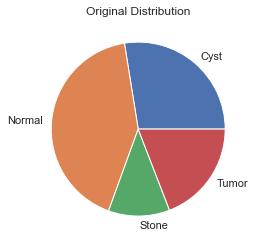

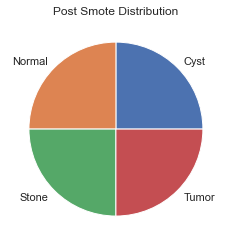

In [73]:
# SMOTE to balance classes

# Original class distribution
unique, counts = np.unique(y_train_new, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
XsmoteNew, ysmoteNew = oversample.fit_resample(X_train_new, y_train_new)


# Updated class distribution
uniquesmote, countssmote = np.unique(ysmoteNew, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [115]:
np.random.seed(42)
indices = np.arange(Xsmote.shape[0])
shuffled_indices = np.random.permutation(indices)
X_trainshuf_new = XsmoteNew[shuffled_indices]
y_trainshuf_new = ysmoteNew[shuffled_indices]
print(X_train_new.shape)
print(X_trainshuf_new.shape)
print(y_trainshuf_new.shape)

indices = np.arange(X_val_new.shape[0])
shuffled_indices = np.random.permutation(indices)
X_valshuf_new = X_val_new[shuffled_indices]
y_valshuf_new = y_val_new[shuffled_indices]
print(X_val_new.shape)
print(X_valshuf_new.shape)
print(y_valshuf_new.shape)


indices = np.arange(X_test_new.shape[0])
shuffled_indices = np.random.permutation(indices)
X_testshuf_new = X_test_new[shuffled_indices]
y_testshuf_new = y_test_new[shuffled_indices]
print(X_test_new.shape)
print(X_testshuf_new.shape)
print(y_testshuf_new.shape)

(7156, 65536)
(12004, 65536)
(12004,)
(2384, 65536)
(2384, 65536)
(2384, 1)
(2389, 65536)
(2389, 65536)
(2389, 1)


## OLD PREPROCESSING FLOW BELOW

In [ ]:
# Concatenate all list of images, and turn into a data frame

allImages = cystImages + stoneImages + normalImages + tumorImages

imgs = pd.DataFrame(allImages)

In [ ]:
imgs

In [ ]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

In [ ]:
# Merge with the other dataframe to get each image matched with its label
imgWithLabel = imgs.merge(df, how = 'inner', on = 'image_id')
imgWithLabel = imgWithLabel[['image', 'target']]

In [ ]:
X = imgWithLabel['image'].to_numpy()
y = imgWithLabel['target'].to_numpy()

In [ ]:
if carrigan:
  X = np.load('/content/drive/MyDrive/Kidney Project Data/X.npy', allow_pickle=True)
  y = np.load('/content/drive/MyDrive/Kidney Project Data/y.npy', allow_pickle=True)

### Drop Duplicates

In [ ]:
# Reshape/ unpack the array of images, then flatten it so it is prepared for smote
X = np.array([x for x in X])
print(X.shape)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
print(X.shape)

In [ ]:
X_and_y = np.column_stack((X, y))
print(X_and_y.shape)

In [ ]:
X_and_y = pd.DataFrame(X_and_y)
X_and_y = X_and_y.drop_duplicates()
print(X_and_y.shape)

In [ ]:
X = X_and_y.iloc[:,:-1].to_numpy()
y = X_and_y.iloc[:,-1:].to_numpy()
print(X.shape)
print(y.shape)

### Perform SMOTE

In [ ]:
# Divide by 255, keep as float32 data
# print(np.max(X))
# X = (X.astype(np.float32) / 255.0).astype(np.float32)
# print(np.max(X))

In [ ]:
# SMOTE to balance classes

# Original class distribution
unique, counts = np.unique(y, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X, y)


# Updated class distribution
uniquesmote, countssmote = np.unique(ysmote, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [ ]:
del X
del y
del X_and_y

### Shuffle & reshape the data

In [ ]:
np.random.seed(42)
indices = np.arange(Xsmote.shape[0])
shuffled_indices = np.random.permutation(indices)
Xshuffled = Xsmote[shuffled_indices]
yshuffled = ysmote[shuffled_indices]
print(Xshuffled.shape)

In [ ]:
del Xsmote
del ysmote

### Train and test split

In [ ]:
X_train_flat, X_test_flat, y_train, y_test = train_test_split(Xshuffled, yshuffled, test_size=0.2, random_state=1)

In [ ]:
# Create an intermediary validation set
X_train_flat, X_val_flat, y_train, y_val = train_test_split(X_train_flat, y_train, test_size=0.25, random_state=1)

In [ ]:
# Reshape the data to 4 dimensional data
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))

In [ ]:
del Xshuffled
del yshuffled

### Image Augmentation

In [122]:
# Create augmentation layers
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])


In [ ]:
example_image = X_train[2]
print(example_image.shape)

plt.imshow(example_image)

In [ ]:
plt.figure(figsize=(8, 7))
for i in range(6):
  aug_image = data_augmentation(example_image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(aug_image.numpy()/255)
  plt.axis("off")

In [ ]:
# def rotate_image(image):
#     # Random angle between -20 and 20 degrees
#     angle = np.random.uniform(-20, 20)
#     rotated_image = np.interp(np.arange(len(image)), np.arange(len(image)) + angle, image, left=0, right=0)
#     return rotated_image

# def zoom_image(image):
#     # Random zoom factor between 0.8 and 1.2
#     zoom_factor = np.random.uniform(0.8, 1.2)
#     zoomed_image = np.interp(np.arange(len(image)), np.arange(len(image)) * zoom_factor, image, left=0, right=0)
#     return zoomed_image

# def flip_image(image):
#     # Randomly flip the image horizontally
#     if np.random.rand() > 0.5:
#         flipped_image = np.flip(image)
#     else:
#         flipped_image = image
#     return flipped_image

# def augment_image(image):
#     # Apply rotation
#     rotated_image = rotate_image(image)

#     # Apply zoom
#     zoomed_image = zoom_image(rotated_image)

#     # Apply flip
#     flipped_image = flip_image(zoomed_image)

#     return flipped_image

# # Perform image augmentation on the training data
# X_train_augmented = [augment_image(image) for image in X_train]

# # Convert the augmented data back to NumPy array
# X_train_augmented = np.array(X_train_augmented)

# # Concatenate the original and augmented data
# X_train_combined = np.concatenate((X_train, X_train_augmented))
# y_train_combined = np.concatenate((y_train, y_train.copy()))

# # Ensure X_train_combined and y_train_combined have the correct shapes
# print(X_train_combined.shape)
# print(y_train_combined.shape)



In [ ]:
# X_train = X_train_combined
# y_train = y_train_combined

In [ ]:
# X_train = np.stack(X_train, axis=0)
# Y_train = np.stack(y_train, axis=0)
# X_test = np.stack(X_test, axis=0)
# Y_test = np.stack(y_test, axis=0)

In [117]:
print(np.max(X_trainshuf_new))
X_trainrescale_new = (X_trainshuf_new.astype(np.float32) / 255.0).astype(np.float32)
X_valrescale_new = (X_valshuf_new.astype(np.float32) / 255.0).astype(np.float32)
X_testrescale_new = (X_testshuf_new.astype(np.float32) / 255.0).astype(np.float32)
print(np.max(X_testrescale_new))

255
1.0


## HERE UPDATES OLD NAMES TO NEW NAMES

In [118]:
X_train_flat = X_trainrescale_new
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
y_train = y_trainshuf_new

X_val_flat = X_valrescale_new
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))
y_val = y_valshuf_new

X_test_flat = X_testrescale_new
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
y_test = y_testshuf_new


# Create Models

In [150]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Model 1 - Multiclass Classifier

In [148]:
def build_multiclass_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """

    model = keras.Sequential([
        data_augmentation,
        keras.layers.Flatten(),
        keras.layers.Dense(units=n_classes, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

Epoch 1/15
188/188 [==============================] - 14s 64ms/step - loss: 1.2917 - accuracy: 0.3770 - val_loss: 1.3847 - val_accuracy: 0.3079
Epoch 2/15
188/188 [==============================] - 11s 61ms/step - loss: 1.1690 - accuracy: 0.4927 - val_loss: 1.3385 - val_accuracy: 0.4081
Epoch 3/15
188/188 [==============================] - 12s 63ms/step - loss: 1.1091 - accuracy: 0.5394 - val_loss: 1.4159 - val_accuracy: 0.3167
Epoch 4/15
188/188 [==============================] - 12s 62ms/step - loss: 1.0647 - accuracy: 0.5621 - val_loss: 1.5438 - val_accuracy: 0.2064
Epoch 5/15
188/188 [==============================] - 12s 61ms/step - loss: 1.0252 - accuracy: 0.5932 - val_loss: 1.3756 - val_accuracy: 0.3922
Epoch 6/15
188/188 [==============================] - 12s 62ms/step - loss: 0.9952 - accuracy: 0.6110 - val_loss: 1.4284 - val_accuracy: 0.3435
Epoch 7/15
188/188 [==============================] - 12s 62ms/step - loss: 0.9753 - accuracy: 0.6263 - val_loss: 1.5106 - val_accuracy:

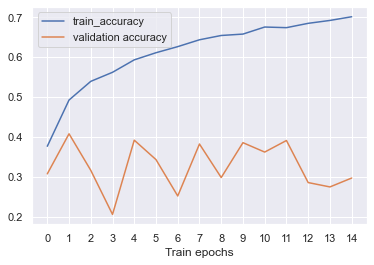

,loss,accuracy,val_loss,val_accuracy
0,1.291729,0.376958,1.384653,0.307886
1,1.168962,0.492669,1.338476,0.408138
2,1.109065,0.539404,1.415913,0.316695
3,1.064744,0.562063,1.543838,0.206376
4,1.025156,0.593219,1.375620,0.392198
5,0.995248,0.611046,1.428377,0.343540
6,0.975335,0.626291,1.510589,0.252517
7,0.948361,0.643452,1.447290,0.382550
8,0.928720,0.654199,1.485687,0.298658
9,0.914867,0.657697,1.438396,0.385906


Training took 2.9536378343900043 minutes


In [149]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model1 = build_multiclass_model(4, 0.001)
numEpochs = 15

startTime = time.time()
history = model1.fit(
  x = X_train,
  y = y_train,
  epochs=numEpochs,
  batch_size=64,
  validation_data = (X_val, y_val),
  verbose=1)
endTime = time.time()

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

history = pd.DataFrame(history.history)
display(history)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [151]:
test_predictions = np.argmax(model1.predict(X_val), axis=-1)
print(test_predictions)

75/75 [==============================] - 0s 2ms/step
[1 0 1 ... 0 1 0]


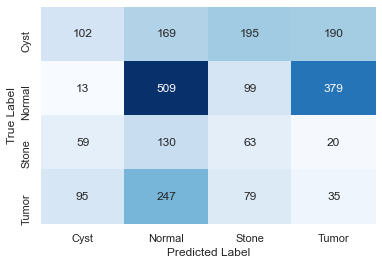

In [152]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Model 2 - Neural Network

In [141]:
def build_model(n_classes,   #should we change the n_classes to 4? since we only have 4 classes
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    model = tf.keras.models.Sequential()
    # Flatten the input shape
    model.add(data_augmentation)
    model.add(tf.keras.layers.Flatten())
    
    # Add hidden layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(layer_size, activation=activation))
    #Add the last neural network layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))
    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")
    return model


Epoch 1/10
188/188 [==============================] - 18s 87ms/step - loss: 1.2574 - accuracy: 0.4069 - val_loss: 1.3286 - val_accuracy: 0.3767
Epoch 2/10
188/188 [==============================] - 16s 87ms/step - loss: 1.1155 - accuracy: 0.5427 - val_loss: 1.2804 - val_accuracy: 0.4505
Epoch 3/10
188/188 [==============================] - 16s 87ms/step - loss: 1.0247 - accuracy: 0.6110 - val_loss: 1.3493 - val_accuracy: 0.3897
Epoch 4/10
188/188 [==============================] - 16s 85ms/step - loss: 0.9600 - accuracy: 0.6490 - val_loss: 1.4819 - val_accuracy: 0.2861
Epoch 5/10
188/188 [==============================] - 16s 85ms/step - loss: 0.9008 - accuracy: 0.6917 - val_loss: 1.2834 - val_accuracy: 0.4241
Epoch 6/10
188/188 [==============================] - 16s 85ms/step - loss: 0.8514 - accuracy: 0.7213 - val_loss: 1.3412 - val_accuracy: 0.4073
Epoch 7/10
188/188 [==============================] - 16s 85ms/step - loss: 0.8105 - accuracy: 0.7462 - val_loss: 1.4083 - val_accuracy:

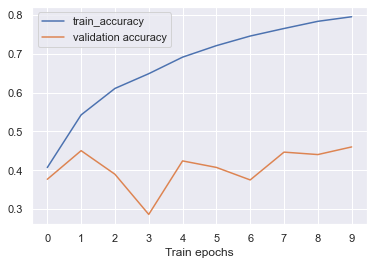

Training took 2.707106932004293 minutes


In [153]:
# Build and compile the model
model2_sgd = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', 
                         optimizer='SGD', learning_rate=0.001)
numEpochs = 10

# Train the model for 5 epochs
startTime = time.time()
history = model2_sgd.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

75/75 [==============================] - 1s 7ms/step


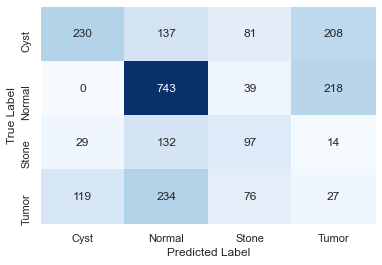

In [154]:
test_predictions = np.argmax(model2_sgd.predict(X_val), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

Epoch 1/10
188/188 [==============================] - 44s 226ms/step - loss: 3.3358 - accuracy: 0.3581 - val_loss: 1.6927 - val_accuracy: 0.2613
Epoch 2/10
188/188 [==============================] - 43s 226ms/step - loss: 1.0775 - accuracy: 0.5556 - val_loss: 1.8469 - val_accuracy: 0.3826
Epoch 3/10
188/188 [==============================] - 42s 224ms/step - loss: 0.7409 - accuracy: 0.6957 - val_loss: 1.7782 - val_accuracy: 0.3083
Epoch 4/10
188/188 [==============================] - 42s 226ms/step - loss: 0.5770 - accuracy: 0.7735 - val_loss: 3.3584 - val_accuracy: 0.1879
Epoch 5/10
188/188 [==============================] - 43s 227ms/step - loss: 0.4804 - accuracy: 0.8121 - val_loss: 2.6541 - val_accuracy: 0.3297
Epoch 6/10
188/188 [==============================] - 42s 226ms/step - loss: 0.3969 - accuracy: 0.8490 - val_loss: 3.4741 - val_accuracy: 0.3016
Epoch 7/10
188/188 [==============================] - 43s 227ms/step - loss: 0.3486 - accuracy: 0.8722 - val_loss: 2.7199 - val_ac

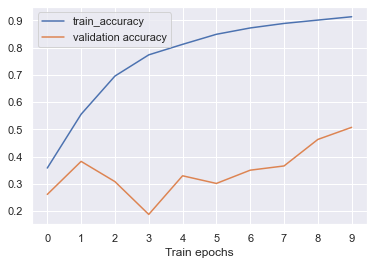

Training took 7.115969769159952 minutes


In [157]:
model2_rms = build_model(n_classes=4, hidden_layer_sizes=[256], activation='relu', 
                         optimizer='RMSprop', learning_rate=0.001)

numEpochs = 10

# Train the model for 5 epochs
startTime = time.time()
history = model2_rms.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

75/75 [==============================] - 1s 11ms/step


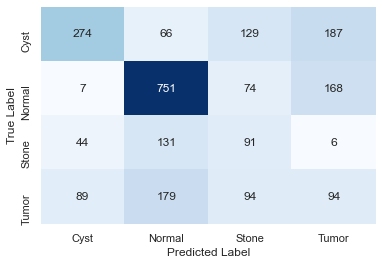

In [158]:
test_predictions = np.argmax(model2_rms.predict(X_val), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

Epoch 1/10
188/188 [==============================] - 29s 139ms/step - loss: 1.8593 - accuracy: 0.5188 - val_loss: 2.4428 - val_accuracy: 0.2605
Epoch 2/10
188/188 [==============================] - 26s 136ms/step - loss: 0.8141 - accuracy: 0.6941 - val_loss: 1.8180 - val_accuracy: 0.4174
Epoch 3/10
188/188 [==============================] - 26s 138ms/step - loss: 0.5532 - accuracy: 0.8004 - val_loss: 1.9671 - val_accuracy: 0.3842
Epoch 4/10
188/188 [==============================] - 26s 136ms/step - loss: 0.4430 - accuracy: 0.8441 - val_loss: 2.5342 - val_accuracy: 0.3230
Epoch 5/10
188/188 [==============================] - 25s 134ms/step - loss: 0.3422 - accuracy: 0.8822 - val_loss: 2.5620 - val_accuracy: 0.3658
Epoch 6/10
188/188 [==============================] - 25s 135ms/step - loss: 0.2681 - accuracy: 0.9118 - val_loss: 2.7502 - val_accuracy: 0.3574
Epoch 7/10
188/188 [==============================] - 25s 135ms/step - loss: 0.2346 - accuracy: 0.9255 - val_loss: 2.7504 - val_ac

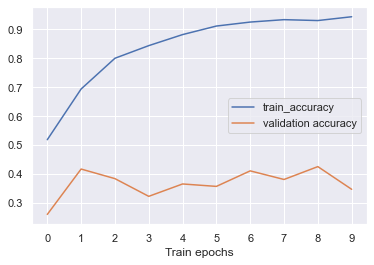

Training took 4.315996448198955 minutes


In [159]:
model2_adam = build_model(n_classes=4, hidden_layer_sizes=[256], activation='relu', 
                          optimizer='Adam', learning_rate=0.001)

numEpochs = 10

# Train the model for 5 epochs
startTime = time.time()
history = model2_adam.fit(X_train, 
                         y_train, 
                         epochs=numEpochs, 
                         batch_size=64, 
                         validation_data = (X_val, y_val),
                         verbose=1)
# test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)
endTime = time.time()

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

75/75 [==============================] - 1s 13ms/step


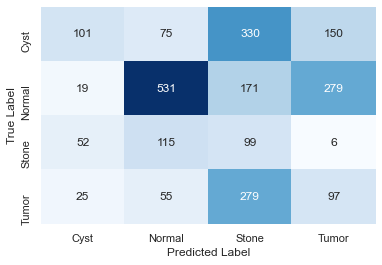

In [160]:
test_predictions = np.argmax(model2_adam.predict(X_val), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Models 3-4 - CNN

In [161]:
def build_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):

    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()
    model.add(data_augmentation)

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [162]:
input_shape = (32, 32, 3)  # Change this according to your image dimensions

In [164]:
#new_shape = (32, 32, 3)
X_train_reshaped = np.reshape(X_train_flat, (-1, 256, 256, 1))
X_val_reshaped = np.reshape(X_val_flat, (-1, 256, 256, 1))
X_test_reshaped = np.reshape(X_test_flat, (-1, 256, 256, 1))
# Normalize pixel values to range [0, 1]
# X_train_reshaped = X_train_reshaped / 255.0
# X_val_reshaped = X_val_reshaped / 255.0
# X_test_reshaped = X_test_reshaped / 255.0


X_train_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_train_reshaped])
X_val_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_val_reshaped])
X_test_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_test_reshaped])


In [165]:
X_train_rgb = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val_resized[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test_resized[..., np.newaxis], 3, axis=-1)

# Reshape to remove the extra dimension
X_train_rgb = np.squeeze(X_train_rgb, axis=3)
X_val_rgb = np.squeeze(X_val_rgb, axis=3)
X_test_rgb = np.squeeze(X_test_rgb, axis=3)


In [176]:
# Train the CNN model for 5 epochs
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.001)
numEpochs = 25
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Epoch 1/25
188/188 [==============================] - 9s 42ms/step - loss: 1.3847 - accuracy: 0.2514 - val_loss: 1.3596 - val_accuracy: 0.4195
Epoch 2/25
188/188 [==============================] - 8s 41ms/step - loss: 1.3783 - accuracy: 0.2497 - val_loss: 1.3550 - val_accuracy: 0.4195
Epoch 3/25
188/188 [==============================] - 8s 42ms/step - loss: 1.3740 - accuracy: 0.2507 - val_loss: 1.3507 - val_accuracy: 0.4195
Epoch 4/25
188/188 [==============================] - 8s 42ms/step - loss: 1.3702 - accuracy: 0.2517 - val_loss: 1.3473 - val_accuracy: 0.4262
Epoch 5/25
188/188 [==============================] - 8s 40ms/step - loss: 1.3664 - accuracy: 0.2580 - val_loss: 1.3425 - val_accuracy: 0.4320
Epoch 6/25
188/188 [==============================] - 8s 41ms/step - loss: 1.3626 - accuracy: 0.2670 - val_loss: 1.3370 - val_accuracy: 0.4404
Epoch 7/25
188/188 [==============================] - 8s 41ms/step - loss: 1.3584 - accuracy: 0.2773 - val_loss: 1.3318 - val_accuracy: 0.4547

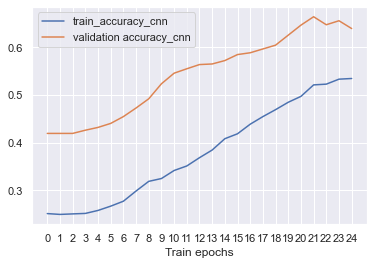

In [177]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

75/75 [==============================] - 0s 4ms/step


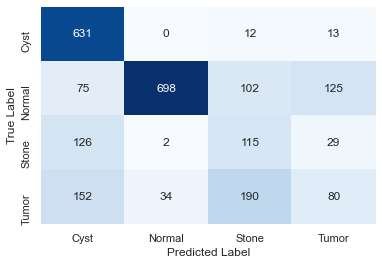

In [178]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [186]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.0001)
numEpochs = 15
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Epoch 1/15
188/188 [==============================] - 10s 43ms/step - loss: 1.2468 - accuracy: 0.4474 - val_loss: 1.3538 - val_accuracy: 0.3335
Epoch 2/15
188/188 [==============================] - 8s 42ms/step - loss: 1.0499 - accuracy: 0.5426 - val_loss: 1.3757 - val_accuracy: 0.3725
Epoch 3/15
188/188 [==============================] - 8s 42ms/step - loss: 0.9102 - accuracy: 0.6035 - val_loss: 1.2751 - val_accuracy: 0.4765
Epoch 4/15
188/188 [==============================] - 8s 43ms/step - loss: 0.7833 - accuracy: 0.6738 - val_loss: 1.2650 - val_accuracy: 0.5172
Epoch 5/15
188/188 [==============================] - 8s 43ms/step - loss: 0.6884 - accuracy: 0.7318 - val_loss: 1.2956 - val_accuracy: 0.5168
Epoch 6/15
188/188 [==============================] - 8s 43ms/step - loss: 0.6178 - accuracy: 0.7666 - val_loss: 1.2187 - val_accuracy: 0.5336
Epoch 7/15
188/188 [==============================] - 8s 43ms/step - loss: 0.5638 - accuracy: 0.7907 - val_loss: 1.4252 - val_accuracy: 0.502

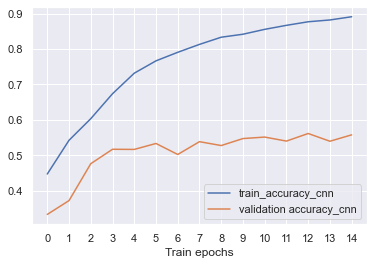

In [187]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

75/75 [==============================] - 0s 3ms/step


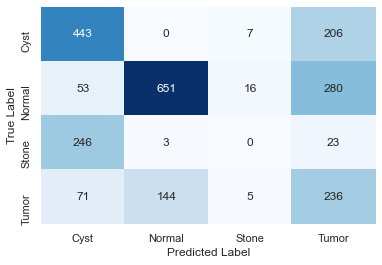

In [188]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [195]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.001)
numEpochs = 10
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Epoch 1/10
188/188 [==============================] - 10s 43ms/step - loss: 1.1140 - accuracy: 0.4943 - val_loss: 2.4977 - val_accuracy: 0.2764
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.7180 - accuracy: 0.7009 - val_loss: 1.3984 - val_accuracy: 0.5067
Epoch 3/10
188/188 [==============================] - 8s 42ms/step - loss: 0.4786 - accuracy: 0.8126 - val_loss: 2.4251 - val_accuracy: 0.4404
Epoch 4/10
188/188 [==============================] - 8s 42ms/step - loss: 0.3251 - accuracy: 0.8783 - val_loss: 2.8800 - val_accuracy: 0.3540
Epoch 5/10
188/188 [==============================] - 8s 43ms/step - loss: 0.2210 - accuracy: 0.9184 - val_loss: 1.9980 - val_accuracy: 0.5877
Epoch 6/10
188/188 [==============================] - 8s 42ms/step - loss: 0.1648 - accuracy: 0.9403 - val_loss: 1.7457 - val_accuracy: 0.5910
Epoch 7/10
188/188 [==============================] - 8s 43ms/step - loss: 0.1166 - accuracy: 0.9623 - val_loss: 3.9302 - val_accuracy: 0.531

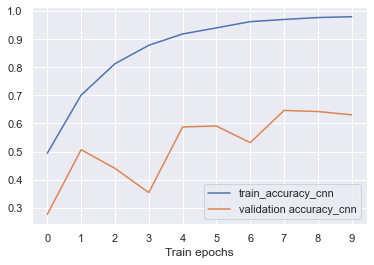

In [196]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

75/75 [==============================] - 0s 4ms/step


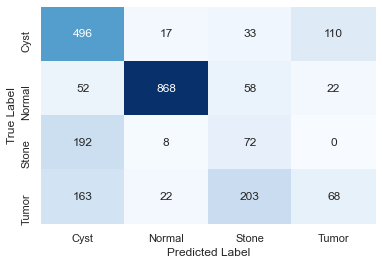

In [197]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [198]:
#building a new CNN model increasing the number of filters

def build_new_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):
    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()
    model.add(data_augmentation)

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Adding drop out layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [212]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.001)
numEpochs = 10
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Epoch 1/10
188/188 [==============================] - 10s 43ms/step - loss: 1.1091 - accuracy: 0.4942 - val_loss: 2.5846 - val_accuracy: 0.2966
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.7167 - accuracy: 0.7041 - val_loss: 1.6284 - val_accuracy: 0.4924
Epoch 3/10
188/188 [==============================] - 8s 42ms/step - loss: 0.4640 - accuracy: 0.8201 - val_loss: 2.3822 - val_accuracy: 0.5583
Epoch 4/10
188/188 [==============================] - 8s 42ms/step - loss: 0.3058 - accuracy: 0.8844 - val_loss: 3.2929 - val_accuracy: 0.3918
Epoch 5/10
188/188 [==============================] - 8s 42ms/step - loss: 0.2115 - accuracy: 0.9230 - val_loss: 3.2029 - val_accuracy: 0.5310
Epoch 6/10
188/188 [==============================] - 8s 43ms/step - loss: 0.1392 - accuracy: 0.9519 - val_loss: 2.7607 - val_accuracy: 0.5390
Epoch 7/10
188/188 [==============================] - 8s 43ms/step - loss: 0.1109 - accuracy: 0.9636 - val_loss: 4.3385 - val_accuracy: 0.546

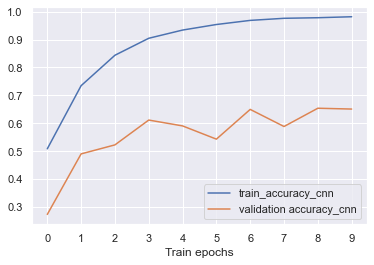

In [202]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

75/75 [==============================] - 0s 3ms/step


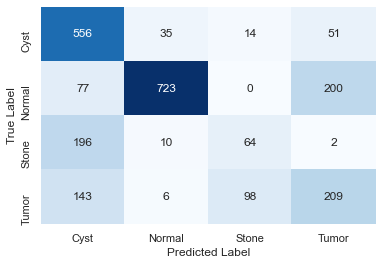

In [203]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [204]:
cnn_model = build_new_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.01)
numEpochs = 20
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Epoch 1/20
188/188 [==============================] - 16s 73ms/step - loss: 1.3834 - accuracy: 0.2783 - val_loss: 1.3603 - val_accuracy: 0.4392
Epoch 2/20
188/188 [==============================] - 14s 73ms/step - loss: 1.3635 - accuracy: 0.3376 - val_loss: 1.2990 - val_accuracy: 0.5872
Epoch 3/20
188/188 [==============================] - 14s 74ms/step - loss: 1.3100 - accuracy: 0.4133 - val_loss: 1.1566 - val_accuracy: 0.6758
Epoch 4/20
188/188 [==============================] - 14s 74ms/step - loss: 1.2159 - accuracy: 0.4511 - val_loss: 1.0537 - val_accuracy: 0.6531
Epoch 5/20
188/188 [==============================] - 14s 74ms/step - loss: 1.1536 - accuracy: 0.4708 - val_loss: 0.9370 - val_accuracy: 0.6388
Epoch 6/20
188/188 [==============================] - 14s 74ms/step - loss: 1.1194 - accuracy: 0.4918 - val_loss: 0.9256 - val_accuracy: 0.6401
Epoch 7/20
188/188 [==============================] - 14s 75ms/step - loss: 1.0974 - accuracy: 0.5028 - val_loss: 0.9749 - val_accuracy:

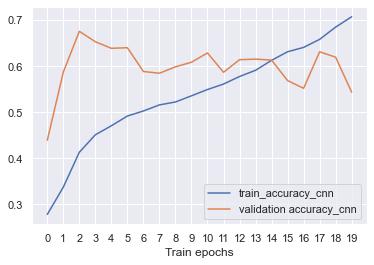

In [205]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

75/75 [==============================] - 1s 11ms/step


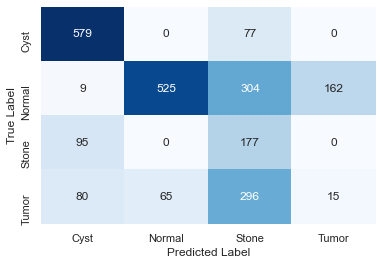

In [206]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [213]:
cnn_model = build_new_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.001)
numEpochs = 15
startTime = time.time()
history_cnn = cnn_model.fit(X_train_rgb, 
                            y_train, 
                            epochs=numEpochs, 
                            batch_size=64, 
                            validation_data = (X_val_rgb, y_val), 
                            verbose=1)
endTime = time.time()
# test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)
print('Training took ' + str((endTime - startTime)/60) + ' minutes')

Epoch 1/15
188/188 [==============================] - 16s 74ms/step - loss: 1.1249 - accuracy: 0.4715 - val_loss: 1.4375 - val_accuracy: 0.5201
Epoch 2/15
188/188 [==============================] - 14s 74ms/step - loss: 0.5830 - accuracy: 0.7578 - val_loss: 1.8267 - val_accuracy: 0.4950
Epoch 3/15
188/188 [==============================] - 14s 74ms/step - loss: 0.2928 - accuracy: 0.8878 - val_loss: 2.1164 - val_accuracy: 0.5801
Epoch 4/15
188/188 [==============================] - 14s 74ms/step - loss: 0.1958 - accuracy: 0.9282 - val_loss: 2.3068 - val_accuracy: 0.5210
Epoch 5/15
188/188 [==============================] - 14s 74ms/step - loss: 0.1137 - accuracy: 0.9595 - val_loss: 3.1478 - val_accuracy: 0.5889
Epoch 6/15
188/188 [==============================] - 14s 75ms/step - loss: 0.0877 - accuracy: 0.9691 - val_loss: 3.1319 - val_accuracy: 0.6275
Epoch 7/15
188/188 [==============================] - 14s 76ms/step - loss: 0.0617 - accuracy: 0.9791 - val_loss: 2.8713 - val_accuracy:

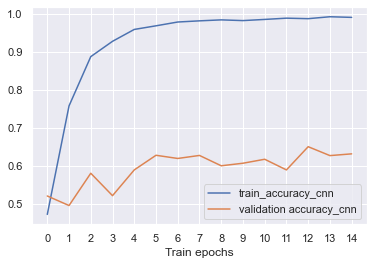

In [214]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(numEpochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

75/75 [==============================] - 1s 12ms/step


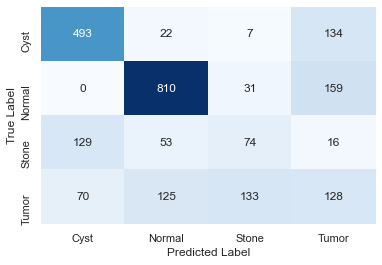

In [215]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Test CNN Model and Create ROC Curve

In [216]:
predictions = cnn_model.predict(X_test_rgb)
class_predictions = np.argmax(predictions, axis=-1)
print(class_predictions)

75/75 [==============================] - 1s 12ms/step
[1 3 0 ... 1 0 0]


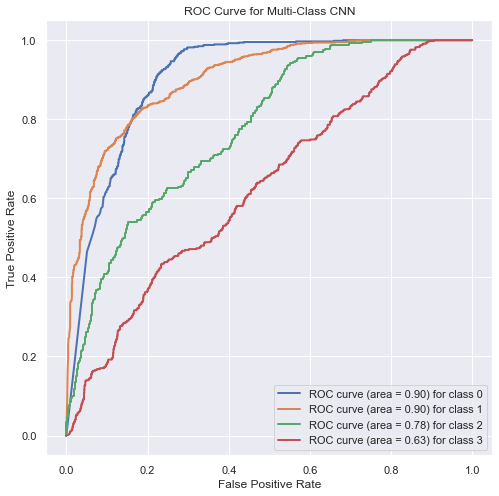

In [217]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class CNN')
plt.legend()
plt.show()

### Model 5 - Transfer Learning

In [218]:
# Should have shape (12004, 256, 256, 1) at start of cell

print(X_train.shape, X_val.shape)
X_train_3_channel = X_train.repeat(3, axis=-1)
X_val_3_channel = X_val.repeat(3, axis = -1)

print(X_train_3_channel.shape, X_val_3_channel.shape)

(12004, 256, 256, 1) (2384, 256, 256, 1)
(12004, 256, 256, 3) (2384, 256, 256, 3)


In [219]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

In [220]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
               keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)


inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model4 = keras.Model(inputs, outputs)

model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_23 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
startTime = time.time()
history = model4.fit(X_train_3_channel, 
                     y_train, 
                     epochs=10, 
                     batch_size=64, 
                     validation_data = (X_val_3_channel, y_val))
endTime = time.time()

print('Training took ' + str((endTime - startTime)/60) + ' minutes')

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [ ]:
test_predictions = np.argmax(cnn_model.predict(X_val_rgb), axis=-1)


# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Model 6 - KNN

In [ ]:
model5 = KNeighborsClassifier(n_neighbors=70, p=2, metric='minkowski')
model5.fit(X_train_flat, y_train)

In [ ]:
y_pred = model5.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

In [ ]:
y_pred = model5.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

### Model 7 - Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
import pydot
from IPython.display import Image, display

In [ ]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
dt.fit(X_train_flat, y_train)
print('Val accuracy:', dt.score(X_val_flat, y_val))
print('Test accuracy:', dt.score(X_test_flat, y_test))

In [ ]:
# Export and visualize the trained tree
import os

output_name = 'iris-decisiontree.jpg'
full_path = os.path.join(os.getcwd(), output_name)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]

graph.write_png(output_name)
print('Output:', full_path)
display(Image(filename=full_path))

### Model 8 - Random Forest

In [ ]:
if len(X_train.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_train.shape[0]
    X_train = X_train.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact


In [ ]:
if len(X_test.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_test.shape[0]
    X_test = X_test.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=4, random_state=42)

# Training the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Making predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = rf_classifier.score(X_test, y_test)
print(f"Random Forest Classifier Accuracy: {accuracy}")

### Model 9 - XGBoost

In [ ]:
model9 = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)
model9.fit(X_train_flat, y_train)

In [ ]:
y_pred = model9.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

In [ ]:
y_pred = model9.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

### Model 10 - ViT (Transfer Learning Vision Transformer)

In [ ]:
# Create base model
image_size = 256
basemodel10 = vit.vit_b16(
    image_size=image_size,
    activation='relu',
    pretrained=True,
    include_top=False
    ,pretrained_top=False
#     ,classes=4
)

# Freeze base model
basemodel10.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = basemodel10(inputs, training = False)
# x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model10 = keras.Model(inputs, outputs)


model10.summary()

In [ ]:
model10.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model10.fit(X_train_3_channel, y_train, epochs=10, batch_size=64, 
            validation_data = (X_val_3_channel, y_val), verbose = 1)

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()